# Lab Two Style Transfer

#### CS8321: Neural Networks and Machine Learning
    
Johnathan Barr - 39854013
<br>
Will Lacey - 45906124

## Lab Description
<em>In this lab you will implement a photo realistic style transfer algorithm, using the work of Li et al. in their universal style transfer paper. An implementation of training a decoder for different scales of VGG has already been implemented for you (https://github.com/8000net/universal-style-transfer-keras). For photo realistic transfer, you will be implementing the smoothing constraint from Li et al. discussed in lecture, as well as adding un-pooling layers to the implementation.</em>

## Import Modules and Initialization

Before we begin, let's import essential packages for data analysis.

In [1]:
from __future__ import division

import multiprocessing.pool
import sys
import os
import tensorflow as tf
import keras.backend as K
import h5py
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import scipy.misc
import scipy.sparse
import scipy.sparse.linalg

from PIL import Image
from pathlib import PurePath
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input, UpSampling2D
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
from numpy.lib.stride_tricks import as_strided
from functools import partial

print(tf.__version__)

Using TensorFlow backend.


2.1.0


## Manipulating VGG and the Decoder

[<strong>10 Points</strong>] Manipulate the above VGG code to use un-pooling layers as in the Photo Realistic Li et al. paper. <strong>Alternatively</strong>, you can use strided convolutions without any pooling steps if you want. You can also use another network besides VGG (such as UNET). 

First lets implement vgg baf;hf

### vgg

In [2]:
def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


def load_weights(model):
    weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            cache_subdir='models',
                            file_hash='253f8cb515780f3b799900260a226db6')
    f = h5py.File(weights_path)
    
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - np.array([103.939, 116.779, 123.68])

Because wed have to train vgg all oer again, we didnt do anything to it.. now for decoder

### decoder

In [3]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x
    
    x = Conv2DTranspose(512, (3, 3), strides=2, padding='same', use_bias=False, name='decoder_block4_transconv')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same', use_bias=False, name='decoder_block3_transconv')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', use_bias=False, name='decoder_block2_transconv')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', use_bias=False, name='decoder_block1_transconv')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

rather than unpooling, we implemented strided convolutions, beause this was not done in vgg, we gon have some problems

## Training the Decoder
[<strong>10 Points</strong>] Train two image decoders that can decode an image from two different convolutional layers from VGG. If using Keras, there is starter code available at the link above. You may use any image dataset you like. <strong>Alternatively</strong>, you may use pre-trained image auto-encoder weights (from anywhere online). Be sure to cite any code or weights you use properly. 

as mentioned before, we stole this code so yea; first lets build the model

### model

In [4]:
def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None, loss_lambda=1):
        self.input_shape = input_shape
        self.target_layer = target_layer
        self.loss_lambda = loss_lambda

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path, compile=False)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)

        self.loss = self.create_loss_fn(self.encoder)

        self.model.compile('adam', self.loss)

    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   self.loss_lambda*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)

    def export_decoder(self):
        self.decoder.save('data/models/our-trained/decoder_%s.h5' % self.target_layer)

the next step is to make training functions, these next few cells do that

### utility

In [5]:
def count_number_of_images(path):
    """
    Counts the number of files within a directory
    """
    white_list_file_types = ['png', 'jpg', 'jpeg', 'bmp', 'ppm']
    num_samples = 0
    
    path, directories, files = next(os.walk(path))
    for directory in directories:
        path_of_dir = path + '/' + directory
        p, ds, fs = next(os.walk(path_of_dir))
        for f in fs:
            for file_type in white_list_file_types: 
                if file_type in f:
                    num_samples += 1
    return num_samples

def format_image(img, is_clipping=False): 
    if is_clipping:
        img = np.clip(img / 255, 0, 1)
    else:
        if np.amin(img) < 0:
            adjust = - np.amin(img)
            img = img + adjust
        img = img.astype(np.float64) / np.amax(img) 
        
    img = 255 * img # Now scale by 255
    return img.astype(np.uint8)

### train

In [6]:
def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()

# This needs to be in scope where model is defined
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, preview_dir_path, image_size=(256, 256), increment=5000):
        test_img = image.load_img(test_img_path)
        
        # Resizing Image
        test_img = test_img.resize(image_size) # Assumes using 3 channels
    
        test_target = image.img_to_array(test_img)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            
            # normalize and convert image then save
            output_img = format_image(output_img)
            imageio.imwrite(out_path, output_img)

        self.iteration += 1

Awesome. everything is ready. lets quickly craete some training vars

In [7]:
# Parameters
train_path = 'data/datasets/badset'
image_size = (256, 256)
batch_size = 4
epochs = 1

target_layer = 1 # ranges from values 1 through 5
loss_lambda = 1 

is_using_callbacks = False
callbacks_image_path = "data/input/content.png"
callbacks_preview_path = "data/output/preview"

### Execute Training

alright. we gucci lets train off of 1 epoch

In [8]:
# Training
gen = create_gen(train_path, image_size, batch_size)

num_samples = count_number_of_images(train_path)
steps_per_epoch = num_samples // batch_size

encoder_decoder = EncoderDecoder(target_layer=target_layer, loss_lambda=loss_lambda)

if (is_using_callbacks):
    callbacks = [OutputPreview(encoder_decoder, callbacks_image_path, 
                               callbacks_preview_path, image_size=image_size)]
    encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,
                                        epochs=epochs, callbacks=callbacks)
else:
    encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=epochs)

encoder_decoder.export_decoder()

Found 4 images belonging to 2 classes.


/Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:44: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 67088957440.0000


Yea.. so as you can tell we didnt want to grow beards and die. this code will work to train an encoder and decoder... but naw we gonna steal more code

## Training Evaluation

[<strong>10 Points</strong>] Show a few images and their reconstructions using each decoder. Comment on any artifacts from the images.

For fun, lets see how bad this is. lets first write some vars

In [9]:
# Parameters
input_image_path = "data/input/content/spaghetti.png"
output_images_dir = 'data/output/our-trained/'

# Preprocessing
input_img = image.load_img(input_image_path)
input_img = input_img.resize(image_size)
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)

lets doooooooo

In [10]:
# Evaluation
for target_layer in range(1, 6):   
    decoder_path = 'data/models/our-trained/decoder_' + str(target_layer) + '.h5'
    encoder_decoder = EncoderDecoder(decoder_path=decoder_path, target_layer=target_layer)

    output_img = encoder_decoder.model.predict([input_img])[0]

    # Convert image to uint8 then save
    output_img = format_image(output_img)
    output_image_path = output_images_dir + 'decoder' + str(target_layer) + '_output.png'
    imageio.imwrite(output_image_path, output_img)

/Users/WillLacey/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:44: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


images have been created, let's see em

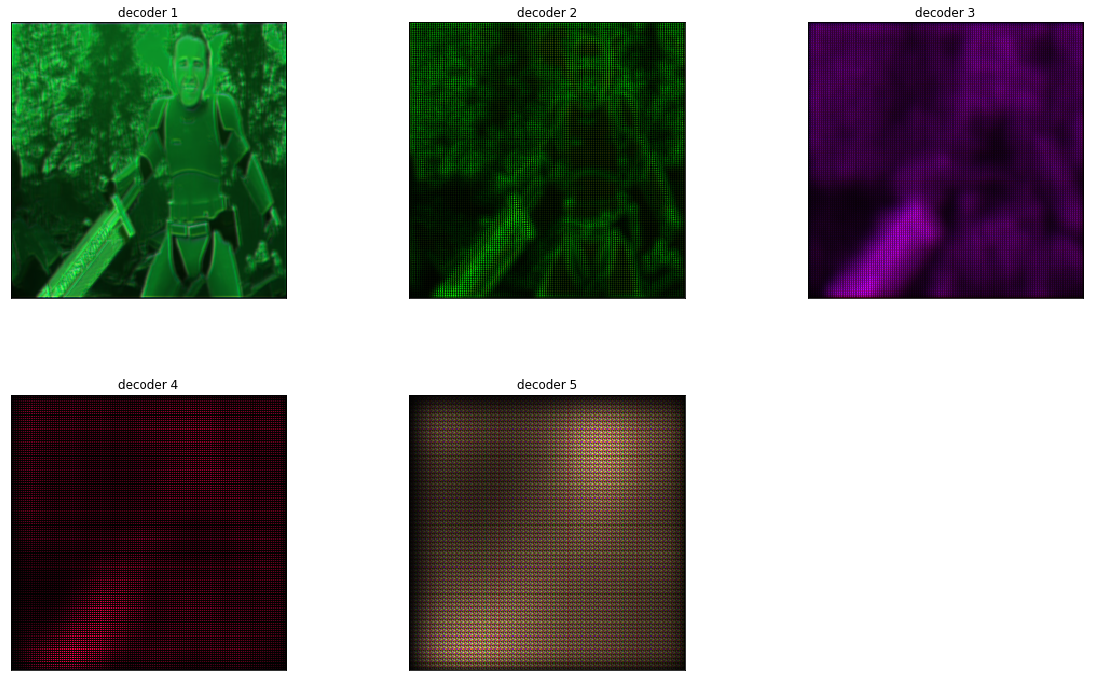

In [11]:
def plot_decoded_image_gallery(image_dir):
    plt.figure(figsize=(16, 10))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for index in range(5):
        plt.subplot(2, 3, index + 1)
        image_path = image_dir + 'decoder' + str(index+1) + '_output.png'
        img = image.load_img(image_path)
        plt.imshow(img)
        plt.title('decoder ' + str(index+1), size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_decoded_image_gallery(output_images_dir)

We didnt train our thing so yea its bad. were using another one now yadayadayad

In [12]:
# -*- coding: utf-8 -*-
class PreTrainedEncoderDecoder(tf.keras.Model):
    def __init__(self, path):
        super(PreTrainedEncoderDecoder, self).__init__()
        #Load Model
        ModelBlock5 = tf.keras.models.load_model(path+'/Block5_Model', compile = False)
        ModelBlock4 = tf.keras.models.load_model(path+'/Block4_Model', compile = False)
        ModelBlock3 = tf.keras.models.load_model(path+'/Block3_Model', compile = False)
        ModelBlock2 = tf.keras.models.load_model(path+'/Block2_Model', compile = False)
        ModelBlock1 = tf.keras.models.load_model(path+'/Block1_Model', compile = False)
        self.model_blocks = [ModelBlock1, ModelBlock2, ModelBlock3, ModelBlock4, ModelBlock5]
        
    def get_encoder_decoder_layer(self, type_of_layer, target_layer):
        model_block = self.model_blocks[target_layer-1]
        if type_of_layer.upper() == 'E' or type_of_layer.upper() == 'ENCODER':
            return model_block.layers[0]
        elif type_of_layer.upper() == 'D' or type_of_layer.upper() == 'DECODER':
            if target_layer == 1:
                print('Error: there is no decoder for first target layer')
                return None
            return model_block.layers[1]
        elif type_of_layer.upper() == 'O' or type_of_layer.upper() == 'OUTPUT':
            if target_layer == 1:
                return model_block.layers[1]
            return model_block.layers[2]
        else:
            print('Error: not a valid layer')
            return None
        
    def encode(self, image, target_layer):
        encoder_layer = self.get_encoder_decoder_layer('encoder', target_layer)
        encoded_image = encoder_layer(image)
        return encoded_image
    
    def decode(self, encoded_image, target_layer):
        if target_layer != 1:
            decoder_layer = self.get_encoder_decoder_layer('decoder', target_layer)
            encoded_image = decoder_layer(encoded_image)
        output_layer = self.get_encoder_decoder_layer('output', target_layer)
        image = output_layer(encoded_image)
        return image
        
    def encode_decode(self, image, target_layer):
        encoded_image = self.encode(image, target_layer)
        image = self.decode(encoded_image, target_layer)
        return image
        

In [13]:
# Parameters
input_image_path = "data/input/content/spaghetti.png"
output_images_dir = 'data/output/pre-trained/'
image_size = (256, 256)

# Preprocessing
input_img = image.load_img(input_image_path)
input_img = input_img.resize(image_size)
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)

In [14]:
print('Loading Pre-Trained EncoderDecoder')
encoder_decoder = PreTrainedEncoderDecoder('data/models/pre-trained')

print('Saving Image Output from Decoders')
for target_layer in range(1, 6):  
    output_img = encoder_decoder.encode_decode(input_img, target_layer=target_layer)
    output_img = format_image(output_img[0].numpy(), is_clipping=False)
    output_image_path = output_images_dir + 'decoder' + str(target_layer) + '_output.png'
    imageio.imwrite(output_image_path, output_img)

Loading Pre-Trained EncoderDecoder
Saving Image Output from Decoders


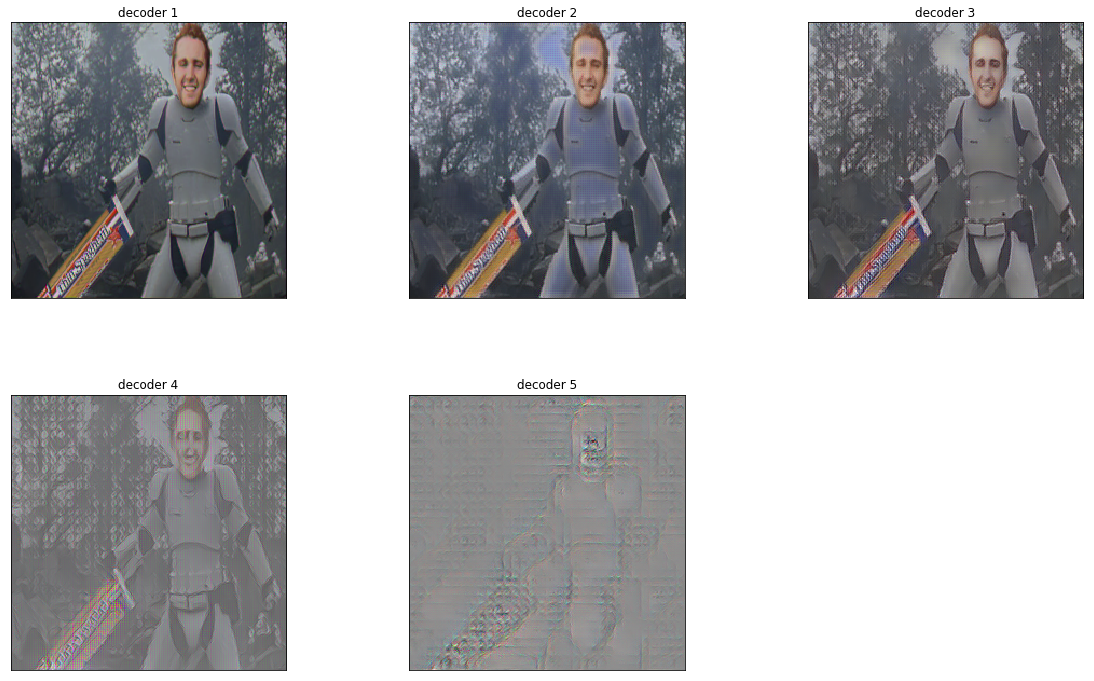

In [15]:
plot_decoded_image_gallery(output_images_dir)

[<strong>10 Points</strong>] Implement the whitening and coloring transform as described by Li et al. An implementation of this has already been written for you, available in the link above. Show a few images that are style transferred using this method. You may use an SVD decomposition or an Eigen Decomposition, depending on the precision of your machine and desired stability. 

In [16]:
def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py
       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)

In [22]:
# Preprocessing
content_image_path = "data/input/content/spaghetti.png"
style_image_dir = "data/input/style/"
style_image_names = ["colorful.png", "drawing.png", "modern.png", "mosaic.png", "pointillism.png",
                     "pointillism2.png", "starry.png"]
output_images_dir = 'data/output/style-transfer/'
image_size = (400, 400)

encoder_decoder = PreTrainedEncoderDecoder('data/models/pre-trained')

In [23]:
for name in style_image_names:
    print('Style Transferring ' + name)
    img_c = image.load_img(content_image_path)
    img_c = img_c.resize(image_size) # Assumes using 3 channels
    img_c = image.img_to_array(img_c)
    img_c_shape = img_c.shape
    img_c = np.expand_dims(img_c, axis=0)
    
    img_s = image.load_img(style_image_dir+name)
    img_s = img_s.resize(image_size) # Assumes using 3 channels
    img_s = image.img_to_array(img_s)
    img_s_shape = img_s.shape
    img_s = np.expand_dims(img_s, axis=0)
    
    assert img_c_shape == img_s_shape, \
    'Content and style image should be the same shape, %s != %s' \
    % (str(img_c_shape), str(img_s_shape))
    
    for i in [5, 4, 3, 2, 1]:
        feats_c = encoder_decoder.encode(img_c, i)
        feats_s = encoder_decoder.encode(img_s, i)
        feats_cs = wct(feats_c, feats_s, alpha=1, eps=1e-5)
        img_c = encoder_decoder.decode(feats_cs, i)
        output_img = format_image(img_c[0].numpy(), is_clipping=True)
        output_image_path = output_images_dir + name[:-4] + '_output'+ str(i) +'.png'
        imageio.imwrite(output_image_path, output_img)    

Style Transferring colorful.png
Style Transferring drawing.png
Style Transferring modern.png
Style Transferring mosaic.png
Style Transferring pointillism.png
Style Transferring pointillism2.png
Style Transferring starry.png


[<strong>10 Points</strong>] Exceptional work: Implement the smoothing constraint from Li et al. to achieve more photo realistic style transfer results. Show a few photo style changes from the network. If using code from another author (not your own), you will be graded on the clarity of explanatory comments you add to the code. 

In [19]:
"""
Copyright (C) 2018 NVIDIA Corporation.    
All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

# model for photorealistic smoothing application
class Propagator(nn.Module):
    def __init__(self, beta=0.9999):
        super(Propagator, self).__init__()
        self.beta = beta

    # function to apply photorealistic smoothing
    def smooth(self, styled_image, content_image):
        # copy arrays so as to not perturb the originals
        content = content_image.copy()
        B = styled_image.copy()
        
        # store the original shape of the style image
        h1,w1,k = B.shape
        
        # resize images in preparation for padding
        h = h1 - 4
        w = w1 - 4
        B = B[int((h1-h)/2):int((h1-h)/2+h),int((w1-w)/2):int((w1-w)/2+w),:]
        content = image.img_to_array(Image.fromarray(np.uint8(content * 255)).resize((h,w)))
        
        # pad both arrays with zeros to address edge cases
        B = self.__replication_padding(B,2)
        content = self.__replication_padding(content,2)
        content = content.astype(np.float64)/255
        B = np.reshape(B,(h1*w1,k))
        
        # compute the laplacian of the content image
        W = self.__compute_laplacian(content)
        
        # convert W matrix to Compressed Sparse Column format
        W = W.tocsc()
        
        # sum the matrix over the first axis
        dd = W.sum(0)
        
        # take the square root of the inverse
        dd = np.sqrt(np.power(dd,-1))

        # convert to ndarray and remove single-dimensional entries from the shape
        dd = dd.A.squeeze()
        
        # convert the ndarray into a Compressed Sparse Column matrix of the original height and width
        D = scipy.sparse.csc_matrix((dd, (np.arange(0,w1*h1), np.arange(0,w1*h1))))
        
        # compute the dot product of D*W*D
        S = D.dot(W).dot(D)
        
        # create an indentity matrix in sparse format of the original size and factorize it
        A = scipy.sparse.identity(w1*h1) - self.beta*S
        
        # convert A matrix to Compressed Sparse Column format
        A = A.tocsc()
        
        # create a function for solving a sparse linear systems, with A pre-factorized
        solver = scipy.sparse.linalg.factorized(A)
        
        # initialize V as array of 0s the size of the original image
        V = np.zeros((h1*w1,k))
        
        # set V to the solved versions of the vectors of B
        V[:,0] = solver(B[:,0])
        V[:,1] = solver(B[:,1])
        V[:,2] = solver(B[:,2])
        
        # scale V based on beta
        V = V*(1-self.beta)
        
        # reshape V to the original image size
        V = V.reshape(h1,w1,k)
        V = V[2:2+h,2:2+w,:]
        
        # generate an image object from the V array and return it
        img = Image.fromarray(np.uint8(np.clip(V * 255., 0, 255.)))
        return img

    # function to calculate sparse matting laplacian
    # The implementation of the function is heavily borrowed from
    # https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
    # We thank Marco Forte for sharing his code.
    def __compute_laplacian(self, img, eps=10**(-7), win_rad=1):
        """Computes Matting Laplacian for a given image.
        Args:
            img: 3-dim numpy matrix with input image
            eps: regularization parameter controlling alpha smoothness from Eq. 12 of the original paper. Defaults to 1e-7.
            win_rad: radius of window used to build Matting Laplacian (i.e. radius of omega_k in Eq. 12).
        Returns: 
            sparse matrix holding matting laplacian.
        """
        
        # calculate the window size based on the window radius
        win_size = (win_rad*2+1)**2
        
        # store the dimensions of the image
        h, w, d = img.shape
        
        # calculate width and height to be used in later reshaping
        c_h, c_w = h - 2*win_rad, w - 2*win_rad
        
        # calcualte window diameter 
        win_diam = win_rad*2+1
        
        # generate evenly spaced values between 0 and h*w and reshape into array with size h x w
        indsM = np.arange(h*w).reshape((h, w))
        
        # convert image from h x w x d to h*w x d (flattening it)
        ravelImg = img.reshape(h*w, d)
        
        # calculate the window indices to be used
        win_inds = self.__rolling_block(indsM, block=(win_diam, win_diam))
        
        # reshape the window indices into a 2D window
        win_inds = win_inds.reshape(c_h, c_w, win_size)
        
        # grab pixel values of the flattened image in the range of the window 
        winI = ravelImg[win_inds]
        
        # calculate the window's mu value which = mean of the window
        win_mu = np.mean(winI, axis=2, keepdims=True)
        
        # calculate the windows variance 
        win_var = np.einsum('...ji,...jk ->...ik', winI, winI)/win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)
        
        # calculate the multiplicative inverse of the matrix
        inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))
        
        # evaluates the Einstein summation convention of the window values
        X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
        
        # taking the average of the window values
        vals = (1/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))
        
        # repeats the indices by the window size and creates contiguous flattened arrays
        nz_indsCol = np.tile(win_inds, win_size).ravel()
        nz_indsRow = np.repeat(win_inds, win_size).ravel()
        nz_indsVal = vals.ravel()
        
        # convert to sparse matrix in COOrdinate format and return
        L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
        return L

    # function to pad the edges of the array with zeros for edge cases
    def __replication_padding(self, arr, pad):
        h,w,c = arr.shape
        ans = np.zeros((h+pad*2,w+pad*2,c))
        for i in range(c):
                ans[:,:,i] = np.pad(arr[:,:,i],pad_width=(pad,pad),mode='edge')
        return ans

    # function to incorporate strided architecture
    def __rolling_block(self, A, block=(3, 3)):
        shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
        strides = (A.strides[0], A.strides[1]) + A.strides
        return as_strided(A, shape=shape, strides=strides)

prop = Propagator()

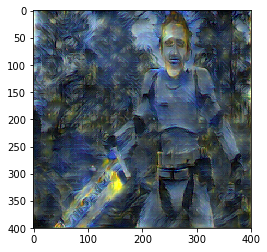

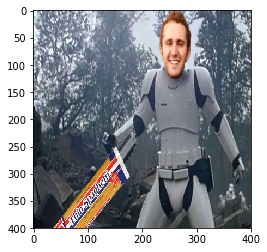

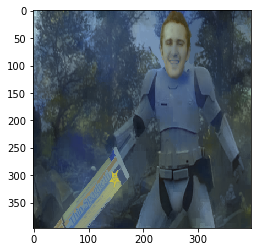

In [47]:
plt.imshow(output_img) # Stylized image
plt.show()

img_c = image.load_img(content_image_path)
img_c = img_c.resize(image_size) # Assumes using 3 channels
img_c = image.img_to_array(img_c)
img_c = format_image(img_c)
plt.imshow(img_c) # content image
plt.show()

smoothed_img = prop.smooth(output_img/255, img_c/255) # og content image
plt.imshow(smoothed_img)
plt.show()